# Import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Dense,Activation,LSTM,GRU,Embedding,Attention,Bidirectional,Concatenate
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


# Read Data

In [ ]:
import pandas as pd

# Read a Parquet file into a DataFrame
df = pd.read_parquet('train-00000-of-00001.parquet')


In [ ]:
df.head()

,fold,subfold,words,segments,pos_tags
0,4,A,"[ليه, لما, تحب, حد, من, قلبك, يطلع, واطى, ليه,...","[ليه, لما, تحب, حد, من, قلب+ك, يطلع, واطى, ليه...","[PART, PART, V, NOUN, PREP, NOUN+PRON, V, ADJ,..."
1,4,A,"[عارف, بيقولك, ايه, "", إذا, أخطأت, فأحسن, "", ....","[عارف, ب+يقو+ل+ك, ايه, "", إذا, أخطأ+ت, ف+أحسن,...","[ADJ, PROG_PART+V+PREP+PRON, PART, PUNC, PART,..."
2,3,A,"[الحمد, لله, يا, جدعان, الفرسان, اللي, اتمسكوا...","[ال+حمد, ل+الله, يا, جدعان, ال+فرسان, اللي, ات...","[DET+NOUN, PREP+NOUN, PART, NOUN, DET+NOUN, PA..."
3,1,A,"[بحس, بشخصيتي, القوية, لما, اقول, لاخويا, اعمل...","[ب+حس, ب+شخصي+ت+ي, ال+قوي+ة, لما, اقول, ل+اخو+...","[PROG_PART+V, PREP+NOUN+NSUFF+PRON, DET+ADJ+NS..."
4,5,A,"[@ahmedabodsheesh, يا, باشا, دي, مش, محتاجه, د...","[@ahmedabodsheesh, يا, باشا, دي, مش, محتاج+ه, ...","[MENTION, PART, NOUN, PRON, PART, ADJ+NSUFF, N..."


# `add tag`
<**start**> and <**end**>

In [ ]:
# add tag <start> and <end> to target columns
df["pos_tags"]=df["pos_tags"].apply(lambda text:f"<start> {text} <end>")


In [ ]:
df.head()

,fold,subfold,words,segments,pos_tags
0,4,A,"[ليه, لما, تحب, حد, من, قلبك, يطلع, واطى, ليه,...","[ليه, لما, تحب, حد, من, قلب+ك, يطلع, واطى, ليه...",<start> ['PART' 'PART' 'V' 'NOUN' 'PREP' 'NOUN...
1,4,A,"[عارف, بيقولك, ايه, "", إذا, أخطأت, فأحسن, "", ....","[عارف, ب+يقو+ل+ك, ايه, "", إذا, أخطأ+ت, ف+أحسن,...",<start> ['ADJ' 'PROG_PART+V+PREP+PRON' 'PART' ...
2,3,A,"[الحمد, لله, يا, جدعان, الفرسان, اللي, اتمسكوا...","[ال+حمد, ل+الله, يا, جدعان, ال+فرسان, اللي, ات...",<start> ['DET+NOUN' 'PREP+NOUN' 'PART' 'NOUN' ...
3,1,A,"[بحس, بشخصيتي, القوية, لما, اقول, لاخويا, اعمل...","[ب+حس, ب+شخصي+ت+ي, ال+قوي+ة, لما, اقول, ل+اخو+...",<start> ['PROG_PART+V' 'PREP+NOUN+NSUFF+PRON' ...
4,5,A,"[@ahmedabodsheesh, يا, باشا, دي, مش, محتاجه, د...","[@ahmedabodsheesh, يا, باشا, دي, مش, محتاج+ه, ...",<start> ['MENTION' 'PART' 'NOUN' 'PRON' 'PART'...


In [ ]:
print(df.loc[0, 'segments'])


['ليه' 'لما' 'تحب' 'حد' 'من' 'قلب+ك' 'يطلع' 'واطى' 'ليه' 'لما' 'تلعب'
 'على' 'واحد' 'يطلع' 'ب+يحب+ك' 'ليه' 'اللى' 'ه+يموت' 'علي+ك' 'انت' 'مش'
 'طايق+ه' 'و+اللى' 'ه+تموت' 'علي+ه' 'مش' 'طايق+ك' 'عجب+ت' 'ل+ك' 'يا' 'زمن'
 'EOS']


# Splitting data into training, testing and validation_data

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting data into training and testing sets input_train, input_test, pos_train, pos_test = train_test_split(input, pos, test_size=0.2)

#input_train, input_test, pos_train, pos_test = train_test_split(df, test_size=0.2, random_state=42)

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

train_data, validation_data = train_test_split(train_data, test_size=0.2, random_state=42)

x_train, y_train = train_data['segments'], train_data['pos_tags']
x_valid, y_valid = validation_data['segments'], validation_data['pos_tags']
x_test, y_test = test_data['segments'], test_data['pos_tags']



# Encoder

In [ ]:
# encoder_vocab
tokenizer=Tokenizer()
#X_train_str = x_train.apply(lambda x: ' '.join(x))
tokenizer.fit_on_texts(x_train.astype(str).tolist())

encoder_vocab=tokenizer.word_index
# encoder_vocab

In [ ]:

x_train_vect=tokenizer.texts_to_sequences(x_train.astype(str).tolist())
x_test_vect=tokenizer.texts_to_sequences(x_test.astype(str).tolist())
x_valid_vect=tokenizer.texts_to_sequences(x_valid.astype(str).tolist())


In [ ]:
############################################

In [ ]:
X=x_train_vect+x_test_vect+x_valid_vect
len(X)

350

In [ ]:
encoder_vocab_size = len(tokenizer.word_index) + 1

max_input_length=max([len(i) for i in X])

In [ ]:
encoder_vocab_size

2009

In [ ]:
max_input_length

64

# Decoder


In [ ]:
tokenizer_decoder=Tokenizer()
tokenizer_decoder.fit_on_texts(y_train.astype(str).tolist())

decoder_vacab=tokenizer_decoder.word_index

In [ ]:
y_train_vect=tokenizer_decoder.texts_to_sequences(y_train.astype(str).tolist())
y_test_vect=tokenizer_decoder.texts_to_sequences(y_test.astype(str).tolist())
y_valid_vect=tokenizer_decoder.texts_to_sequences(y_valid.astype(str).tolist())

In [ ]:
y=y_train_vect+y_test_vect+y_valid_vect

In [ ]:
decoder_vocab_size = len(tokenizer_decoder.word_index) + 1
max_target_length=max([len(i) for i in y])

In [ ]:
decoder_vocab_size

56

In [ ]:
max_target_length

59

# pad sequences
Train

In [ ]:
# pad sequences
encoder_input_seqs=pad_sequences(x_train_vect , maxlen=max_input_length , padding="pre")
# decoder_input_seqs=pad_sequences(decoder_input,maxlen=max_target_length,padding="post")
# decoder_output_seqs=pad_sequences(decoder_output,maxlen=max_target_length,padding="post")
decoder_input_seqs = pad_sequences([seq[:-1] for seq in y_train_vect],
                                   maxlen=max_target_length, padding="post")
decoder_output_seqs = pad_sequences([seq[1:] for seq in y_train_vect],
                                    maxlen=max_target_length, padding="post")


# pad sequences
Validation

In [ ]:
encoder_valid_seqs=pad_sequences(x_valid_vect , maxlen=max_input_length , padding="pre")

decoder_valid_input_seqs = pad_sequences([seq[:-1] for seq in y_valid_vect],
                                         maxlen=max_target_length, padding="post")
decoder_valid_output_seqs = pad_sequences([seq[1:] for seq in y_valid_vect],
                                          maxlen=max_target_length, padding="post")

# pad sequences
Test

In [ ]:
encoder_test_seqs=pad_sequences(x_test_vect, maxlen=max_input_length , padding="pre")

decoder_test_input_seqs = pad_sequences([seq[:-1] for seq in y_test_vect],
                                        maxlen=max_target_length, padding="post")
decoder_test_output_seqs = pad_sequences([seq[1:] for seq in y_test_vect],
                                         maxlen=max_target_length, padding="post")

In [ ]:
#########################################MODEL#######################################

In [ ]:
#Early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:
#new

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Attention, Concatenate
from tensorflow.keras.models import Model

# Hyperparameters
EMBEDDING_DIM = 256
LSTM_UNITS = 256

# Define the encoder
encoder_input = Input(shape=(None,), name='encoder_input')
encoder_embedding = Embedding(encoder_vocab_size, EMBEDDING_DIM, name='encoder_embedding')(encoder_input)
_, state_h, state_c = LSTM(LSTM_UNITS, return_state=True, name='encoder_lstm')(encoder_embedding)
encoder_states = [state_h, state_c]

# Define the decoder
decoder_input = Input(shape=(None,), name='decoder_input')
decoder_embedding = Embedding(decoder_vocab_size, EMBEDDING_DIM, name='decoder_embedding')(decoder_input)
decoder_lstm = LSTM(LSTM_UNITS, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Attention mechanism
attention_layer = Attention(use_scale=True, name='attention_layer')
attention_output = attention_layer([decoder_outputs, state_h])

# Concatenate attention output and decoder output
decoder_combined_context = Concatenate(axis=-1, name='concatenate_layer')([attention_output, decoder_outputs])

# Dense layer for POS tags prediction
dense_layer = Dense(decoder_vocab_size, activation='softmax', name='output_layer')
output = dense_layer(decoder_combined_context)

# Create the model
model = Model([encoder_input, decoder_input], output)

# Print model summary
# model.summary()

# Compile the model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
BATCH_SIZE = 64
EPOCHS = 1000
history = model.fit(
    [encoder_input_seqs, decoder_input_seqs],
    decoder_output_seqs,
    validation_data=([encoder_valid_seqs, decoder_valid_input_seqs], decoder_valid_output_seqs),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,callbacks=[early_stopping]
)


Epoch 1/1000
4/4 [==============================] - 5s 441ms/step - loss: 3.7031 - accuracy: 0.2606 - val_loss: 3.6314 - val_accuracy: 0.3808
Epoch 2/1000
4/4 [==============================] - 1s 151ms/step - loss: 3.0758 - accuracy: 0.3693 - val_loss: 2.6403 - val_accuracy: 0.3808
Epoch 3/1000
4/4 [==============================] - 0s 105ms/step - loss: 2.6776 - accuracy: 0.3711 - val_loss: 2.7705 - val_accuracy: 0.3808
Epoch 4/1000
4/4 [==============================] - 1s 182ms/step - loss: 2.7363 - accuracy: 0.3766 - val_loss: 2.4963 - val_accuracy: 0.3935
Epoch 5/1000
4/4 [==============================] - 0s 111ms/step - loss: 2.6437 - accuracy: 0.3875 - val_loss: 2.8417 - val_accuracy: 0.3898
Epoch 6/1000
4/4 [==============================] - 0s 132ms/step - loss: 2.6071 - accuracy: 0.3745 - val_loss: 2.3671 - val_accuracy: 0.3880
Epoch 7/1000
4/4 [==============================] - 1s 139ms/step - loss: 2.3707 - accuracy: 0.3897 - val_loss: 2.2806 - val_accuracy: 0.4062
Epoch 

(0.0, 4.0)

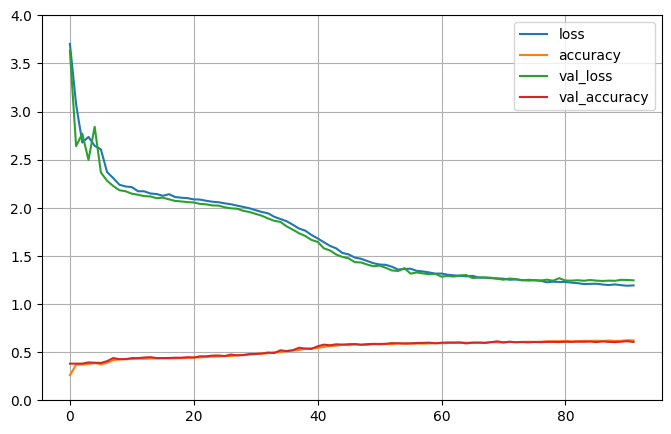

In [ ]:
import pandas as pd
plt=pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.set_ylim(0, 4) # set the vertical range to [0-1] plt.show()

In [ ]:
loss, accuracy = model.evaluate(x=[encoder_test_seqs, decoder_test_input_seqs], y=decoder_test_output_seqs)


3/3 [==============================] - 0s 26ms/step - loss: 1.2593 - accuracy: 0.6111


In [ ]:
import numpy as np

# Sample input text
input_text = "'ليه' 'لما' 'تحب' 'حد' 'من' 'قلب+ك' 'يطلع' 'واطى' 'ليه' 'لما' 'تلعب' 'على' 'واحد' 'يطلع' 'ب+يحب+ك' 'ليه' 'اللى' 'ه+يموت' 'علي+ك' 'انت' 'مش' 'طايق+ه' 'و+اللى' 'ه+تموت' 'علي+ه' 'مش' 'طايق+ك' 'عجب+ت' 'ل+ك' 'يا' 'زمن' 'EOS'"


# Print the input text
print(f"Input Text: {input_text}")

# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts([input_text])  # Use a list even for a single text

# Convert input text to sequences
input_sequence = tokenizer.texts_to_sequences([input_text])

# Pad the input sequence
padded_input_sequence = pad_sequences(input_sequence, maxlen=max_input_length, padding="pre")

# Model prediction
predicted_probabilities = model.predict([padded_input_sequence, np.zeros((1, 1))])

# Assuming your output layer is a softmax layer
predicted_token_index = np.argmax(predicted_probabilities[0, -1, :])

# Convert the index to the corresponding word
predicted_token = tokenizer_decoder.index_word.get(predicted_token_index, '<unk>')

print(f"Predicted Token: {predicted_token}")


Input Text: 'ليه' 'لما' 'تحب' 'حد' 'من' 'قلب+ك' 'يطلع' 'واطى' 'ليه' 'لما' 'تلعب' 'على' 'واحد' 'يطلع' 'ب+يحب+ك' 'ليه' 'اللى' 'ه+يموت' 'علي+ك' 'انت' 'مش' 'طايق+ه' 'و+اللى' 'ه+تموت' 'علي+ه' 'مش' 'طايق+ك' 'عجب+ت' 'ل+ك' 'يا' 'زمن' 'EOS'
1/1 [==============================] - 0s 22ms/step
Predicted Token: 'part'


In [ ]:
import numpy as np

# Sample input text
input_text = 'ليه لما تحب حد من قلب+ك يطلع واطى ليه لما تلعب على واحد يطلع ب+يحب+ك ليه اللى ه+يموت علي+ك انت مش طايق+ه و+اللى ه+تموت علي+ه مش طايق+ك عجب+ت ل+ك يا زمن EOS'

# Split the input text into a list of words
word_list = input_text.split()

# Initialize an empty list to store predicted POS tags
predicted_pos_tags = []

# Iterate through each word in the list
for word in word_list:
    # Tokenize the word
    input_sequence = tokenizer.texts_to_sequences([word])

    # Pad the input sequence
    padded_input_sequence = pad_sequences(input_sequence, maxlen=max_input_length, padding="pre")

    # Model prediction
    predicted_probabilities = model.predict([padded_input_sequence, np.zeros((1, 1))])

    # Assuming your output layer is a softmax layer
    predicted_token_index = np.argmax(predicted_probabilities[0, -1, :])

    # Convert the index to the corresponding word
    predicted_token = tokenizer_decoder.index_word.get(predicted_token_index, '<unk>')

    # Append the predicted POS tag to the list
    predicted_pos_tags.append(predicted_token)

# Display the result
print("Input Text:", input_text)
print("Word List:", word_list)
print("Predicted POS Tags:", predicted_pos_tags)


1/1 [==============================] - 0s 19ms/step
Input Text: ليه لما تحب حد من قلب+ك يطلع واطى ليه لما تلعب على واحد يطلع ب+يحب+ك ليه اللى ه+يموت علي+ك انت مش طايق+ه و+اللى ه+تموت علي+ه مش طايق+ك عجب+ت ل+ك يا زمن EOS
Word List: ['ليه', 'لما', 'تحب', 'حد', 'من', 'قلب+ك', 'يطلع', 'واطى', 'ليه', 'لما', 'تلعب', 'على', 'واحد', 'يطلع', 'ب+يحب+ك', 'ليه', 'اللى', 'ه+يموت', 'علي+ك', 'انت', 'مش', 'طايق+ه', 'و+اللى', 'ه+تموت', 'علي+ه', 'مش', 'طايق+ك', 'عجب+ت', 'ل+ك', 'يا', 'زمن', 'EOS']
Predicted POS Tags: ["'part'", "'part'", "'part'", "'part'", "'part'", "'part'", "'part'", "'part'", "'part'", "'part'", "'part'", "'part'", "'part'", "'part'", "'part'", "'part'", "'part'", "'part'", "'part'", "'part'", "'part'", "'part'", "'part'", "'part'", "'part'", "'part'", "'part'", "'part'", "'part'", "'part'", "'part'", "'part'"]
